In [4]:
!pip install tensorflow pandas scikit-learn matplotlib tqdm --quiet

# Predicción de Regalías con LSTM Multivariado
### Tesis de Maestría en Ciencia de Datos
Este notebook implementa una red neuronal LSTM multivariada para predecir regalías mensuales por artista.
Se entrenan modelos por artista, se calculan métricas y se exportan los resultados para visualización en Power BI.

In [5]:
import pandas as pd
#file_id = '14dqOhZOxoLZVI0vtsf03g_VSJsm05Me_' #version 1
file_id = '19rKtmLEbIyBd0b5HUxBzXxJb92YegK8W' #version 2
url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(url)
df['fecha'] = pd.to_datetime(df['fecha'], format='%m/%d/%Y')
df.head()

,songstats_artist_id,fecha,royalties,instagram_followers,twitter_followers,track_release,sentiment,seguidores_menciones,cant_posteos,cant_comentarios,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_seguidores_menciones_3m,month
0,436lvfnz,2022-07-01,94291.905,5250688,643908,1,0.649123,26326461,3,57,94291.90500,0.00000,0,0,1,0.649123,26326461,7
1,436lvfnz,2022-08-01,90967.300,5283706,647332,0,0.493088,26326461,7,217,92629.60250,23347.25170,3424,33018,1,0.571105,52652922,8
2,436lvfnz,2022-09-01,96849.325,5316966,648728,1,0.703297,0,5,91,94036.17667,33139.07363,1396,33260,2,0.615169,52652922,9
3,436lvfnz,2022-10-01,94944.180,5346661,649390,0,0.548611,50734,5,144,94263.17750,41478.03735,662,29695,2,0.581665,26377195,10
4,436lvfnz,2022-11-01,93308.900,5403544,649732,1,0.557554,26326461,10,278,94072.32200,58780.37927,342,56883,3,0.603154,26377195,11


In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm.notebook import tqdm

def create_sequences(X, y, lookback=3):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

results = []
predictions_output = []

for artist_id, group in tqdm(df.groupby("songstats_artist_id")):
    group = group.sort_values("fecha")
    if len(group) < 15:
        continue

    features = ["instagram_followers", "twitter_followers", "track_release", "sentiment", "seguidores_menciones", "cant_posteos", "cant_comentarios", "mean_royalties_6m", "std_instagram_followers_6m", "growth_twitter_followers", "growth_instagram_followers", "sum_track_releases_6m", "mean_sentiment_3m", "sum_seguidores_menciones_3m", "month"]
    target = "royalties"

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(group[features])
    y_scaled = scaler_y.fit_transform(group[[target]])

    lookback = 3
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback)
    if len(X_seq) < 5:
        continue

    train_size = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(lookback, len(features))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, verbose=0)

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_inv = scaler_y.inverse_transform(y_test)

    mse = mean_squared_error(y_test_inv, y_pred)
    mae = mean_absolute_error(y_test_inv, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred)

    results.append({
        "Artist_ID": artist_id,
        "Modelo": "LSTM",
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

    fechas = group['fecha'].values[lookback+train_size:]
    for i in range(len(y_pred)):
        predictions_output.append({
            "songstats_artist_id": artist_id,
            "fecha": fechas[i],
            "royalties_real": y_test_inv[i][0],
            "royalties_pred": y_pred[i][0],
            "modelo": "LSTM"
        })

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


In [7]:
df_results = pd.DataFrame(results)
df_results.to_csv("lstm_metrics_por_artista.csv", index=False)

df_preds = pd.DataFrame(predictions_output)
df_preds.to_csv("lstm_predicciones_para_powerbi.csv", index=False)
df_results.head()

,Artist_ID,Modelo,MSE,MAE,RMSE,MAPE
0,436lvfnz,LSTM,1.030410e+09,28113.473646,32099.996796,0.164782
1,5jwhbt0o,LSTM,1.332542e+06,898.196608,1154.357737,0.075374
2,5t4iv6o3,LSTM,2.490452e+09,40722.035417,49904.427394,0.112311
3,65m1vtnc,LSTM,6.224412e+09,70992.072813,78894.940340,0.102386
4,67gc5xm9,LSTM,3.450767e+09,51285.300938,58743.231220,0.121873


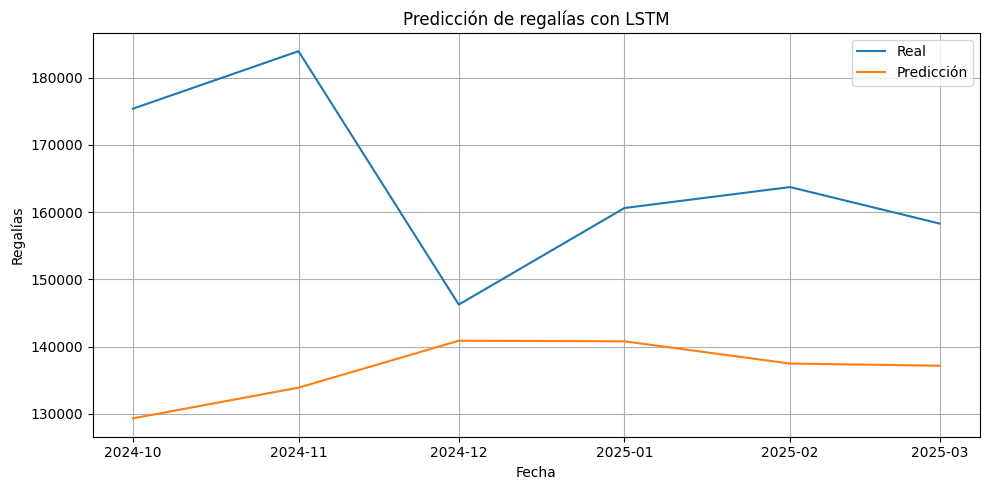

In [8]:
import matplotlib.pyplot as plt

ejemplo = df_preds[df_preds["songstats_artist_id"] == df_preds["songstats_artist_id"].unique()[0]]
plt.figure(figsize=(10,5))
plt.plot(ejemplo["fecha"], ejemplo["royalties_real"], label="Real")
plt.plot(ejemplo["fecha"], ejemplo["royalties_pred"], label="Predicción")
plt.title("Predicción de regalías con LSTM")
plt.xlabel("Fecha")
plt.ylabel("Regalías")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Forecast

Como XGBoost, LSTM no "sabe" el futuro. Para predecir más de 1 mes, hay que predecir el siguiente mes, usar esa predicción como input, y repetir (rolling forecast).

También hay que escalar los datos para LSTM (usamos MinMaxScaler generalmente).

In [9]:
def forecast_lstm_por_artista(df, artist_id, steps=6):
    """
    Entrena LSTM por artista y realiza forecast rolling de 6 meses.

    Parámetros:
    - df: DataFrame
    - artist_id: ID del artista
    - steps: cantidad de meses a predecir

    Retorna:
    - forecast_df: DataFrame con predicciones
    - fig: gráfico
    """
    # Filtrar artista
    df_artista = df[df['songstats_artist_id'] == artist_id].copy()
    df_artista = df_artista.sort_values('fecha')

    # Asegurar fechas
    df_artista['fecha'] = pd.to_datetime(df_artista['fecha'])
    df_artista = df_artista.set_index('fecha').asfreq('MS')

    # Escalar royalties
    scaler = MinMaxScaler()
    scaled_royalties = scaler.fit_transform(df_artista[['royalties']])

    # Crear X, y
    X = []
    y = []
    for i in range(1, len(scaled_royalties)):
        X.append(scaled_royalties[i-1])
        y.append(scaled_royalties[i])
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], 1, X.shape[1]))  # (samples, time_steps, features)

    # Crear y entrenar modelo
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # Rolling forecast
    forecasts = []
    last_input = scaled_royalties[-1].reshape((1, 1, 1))
    last_date = df_artista.index[-1]

    for i in range(steps):
        pred_scaled = model.predict(last_input, verbose=0)
        pred_royalties = scaler.inverse_transform(pred_scaled)[0][0]

        pred_date = last_date + pd.DateOffset(months=1)

        forecasts.append({
            'songstats_artist_id': artist_id,
            'fecha_prediccion': pred_date,
            'royalties_forecast': pred_royalties
        })

        # Actualizar para próxima predicción
        last_input = pred_scaled.reshape((1, 1, 1))
        last_date = pred_date

    forecast_df = pd.DataFrame(forecasts)

    # Gráfico
    fig, ax = plt.subplots(figsize=(10, 5))
    df_artista['royalties'].plot(ax=ax, label='Histórico')
    forecast_df.set_index('fecha_prediccion')['royalties_forecast'].plot(ax=ax, label='Forecast', color='orange')
    ax.set_title(f'Forecast LSTM - Artista {artist_id}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Royalties')
    ax.legend()
    plt.tight_layout()
    plt.close(fig)

    return forecast_df, fig


In [10]:
# Lista de artistas
lista_artistas = df['songstats_artist_id'].unique()

# Almacenar resultados
lista_forecasts = []
lista_figuras = []

# Loop
for artist_id in lista_artistas:
    forecast_df, figura = forecast_lstm_por_artista(df, artist_id, steps=6)
    lista_forecasts.append(forecast_df)
    lista_figuras.append((artist_id, figura))

# Consolidar
df_forecasts_consolidado = pd.concat(lista_forecasts, ignore_index=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Gráfico de forecast para el artista 436lvfnz


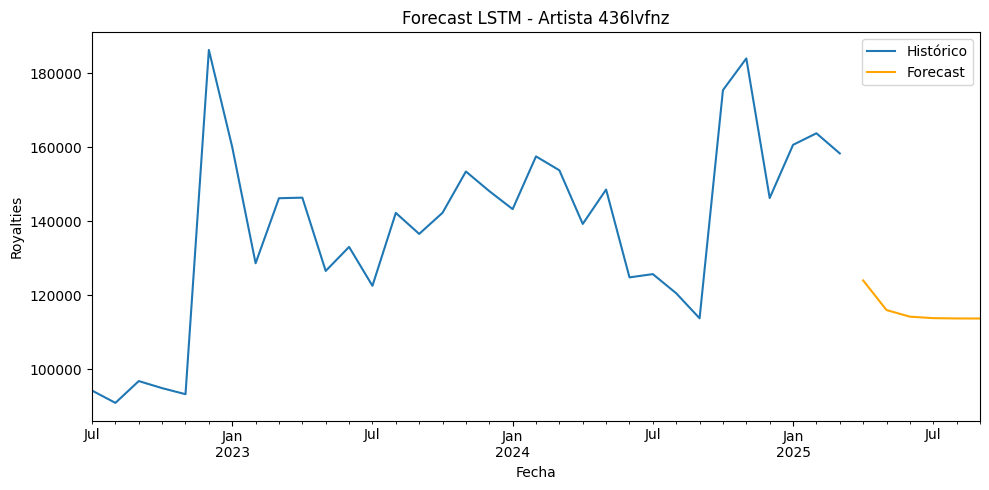

Gráfico de forecast para el artista 5jwhbt0o


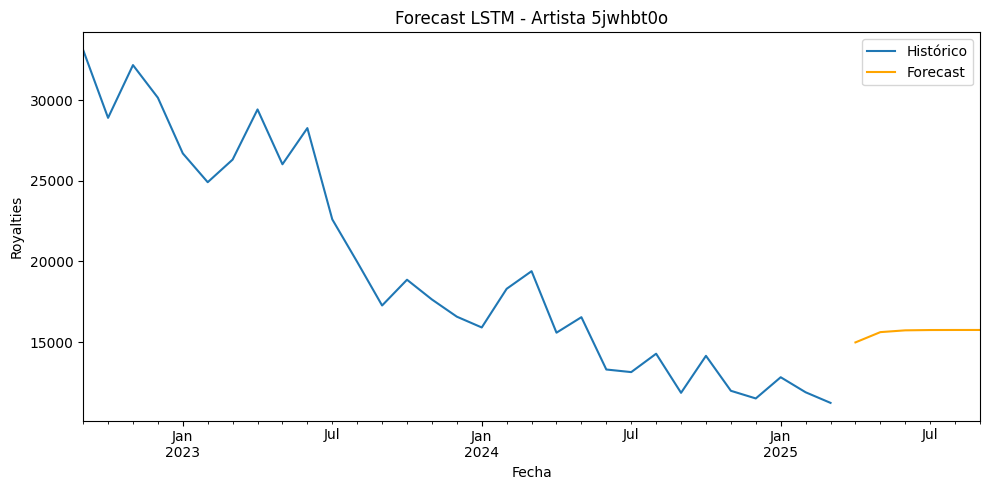

Gráfico de forecast para el artista 5t4iv6o3


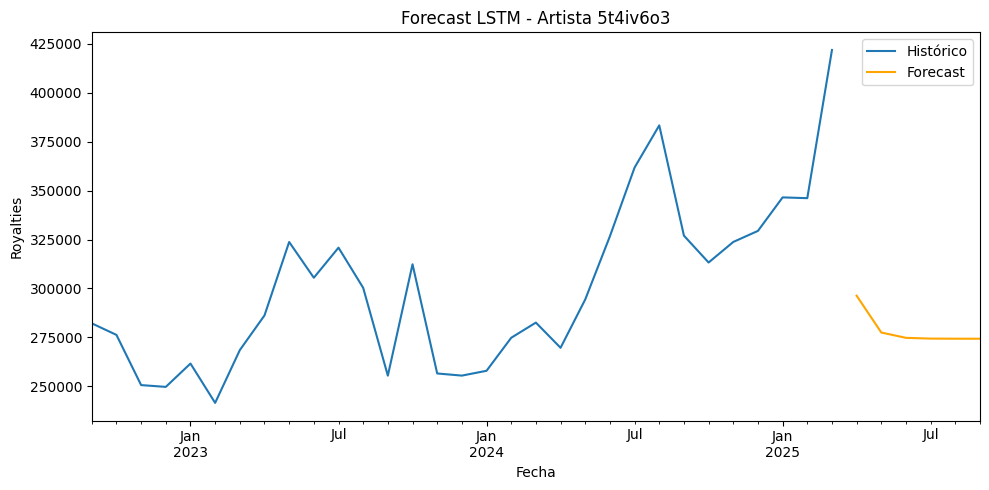

Gráfico de forecast para el artista 65m1vtnc


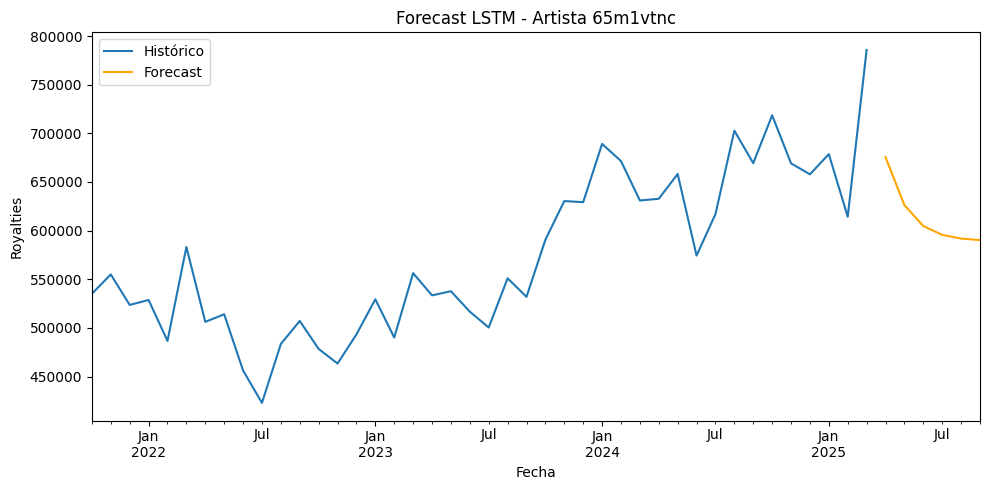

Gráfico de forecast para el artista 67gc5xm9


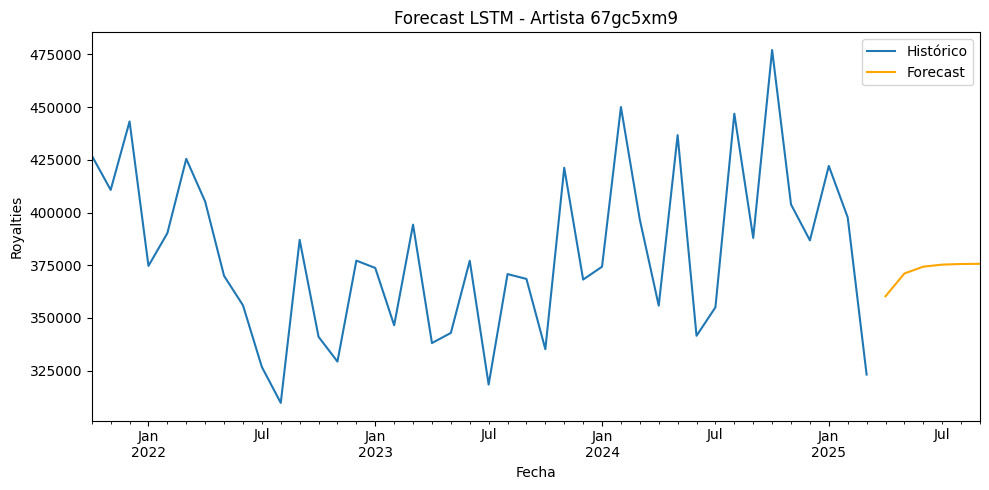

Gráfico de forecast para el artista 6ygz70qs


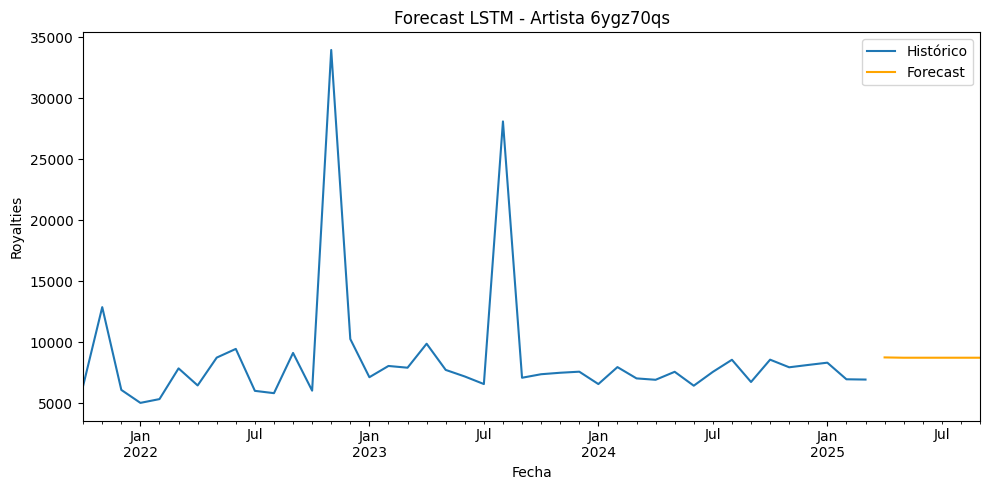

Gráfico de forecast para el artista al0gcvtm


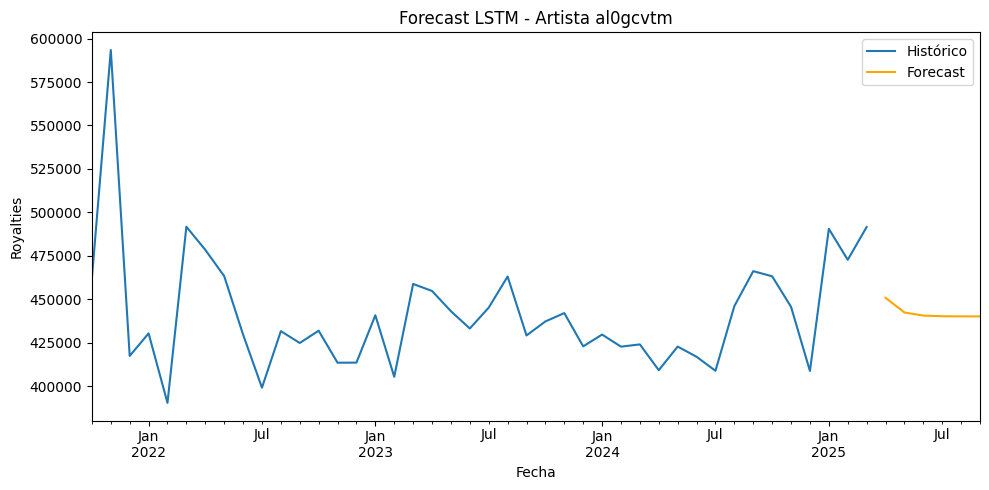

Gráfico de forecast para el artista awrkf92m


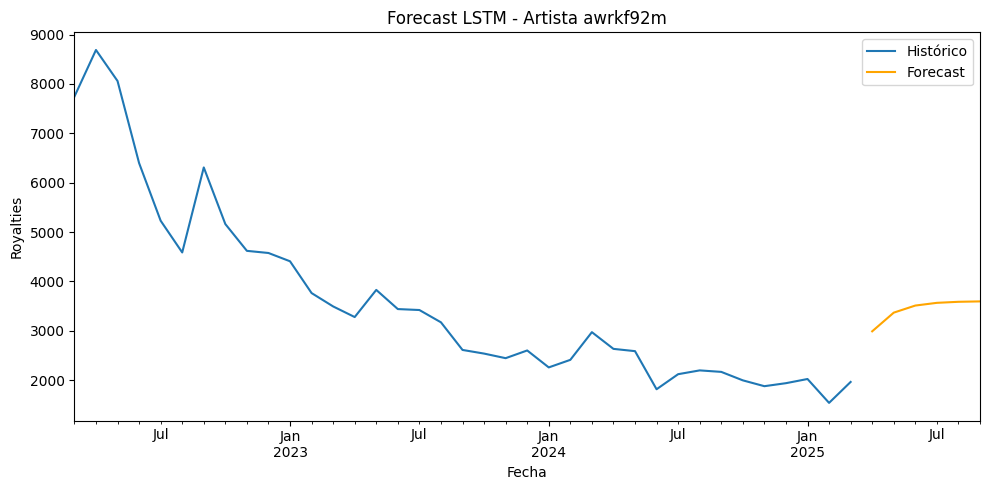

Gráfico de forecast para el artista bpgx7194


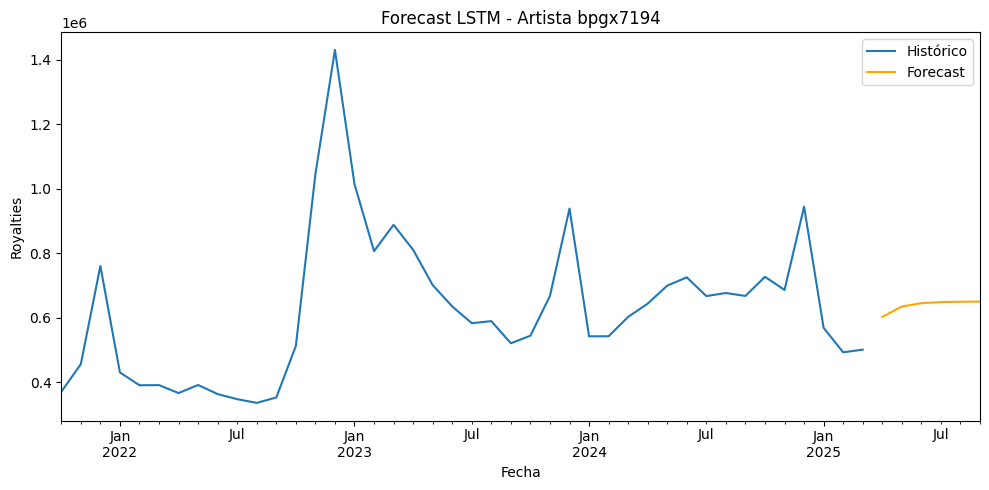

Gráfico de forecast para el artista hfiatnv8


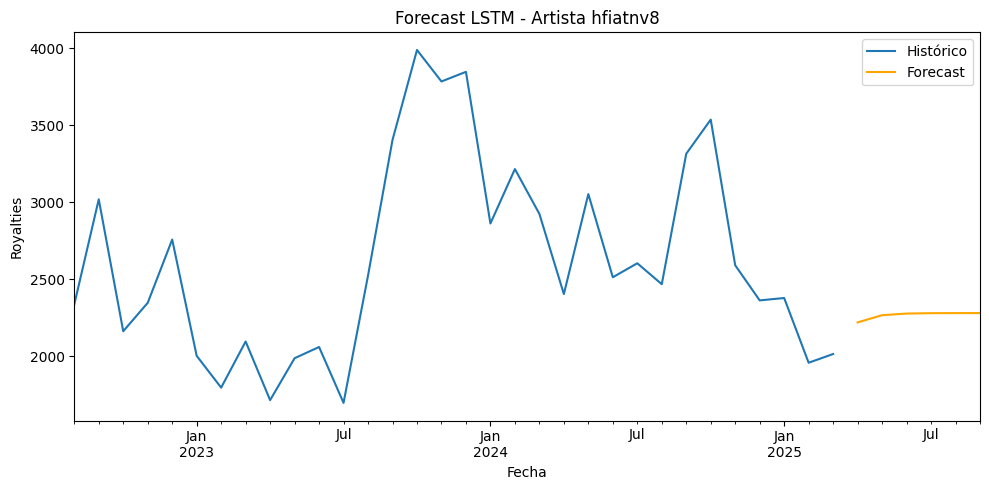

Gráfico de forecast para el artista jla6nu3p


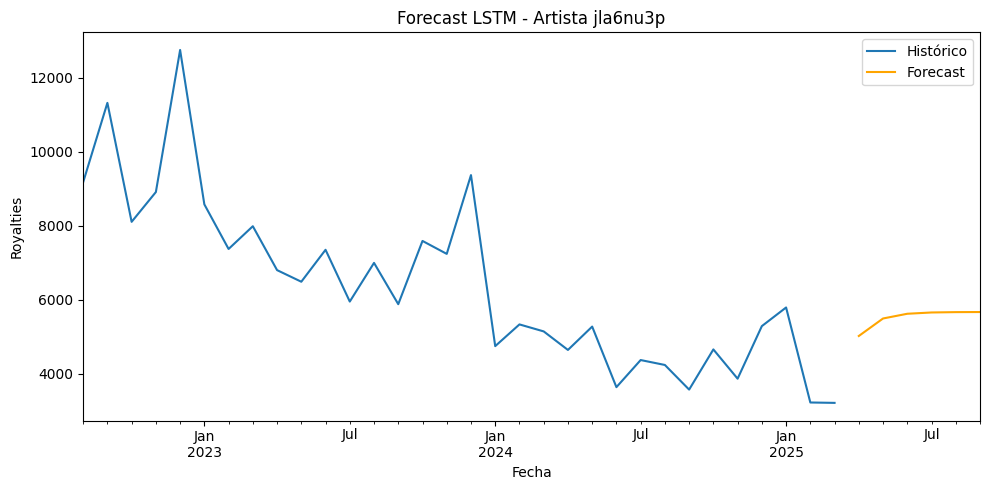

Gráfico de forecast para el artista k74pw1av


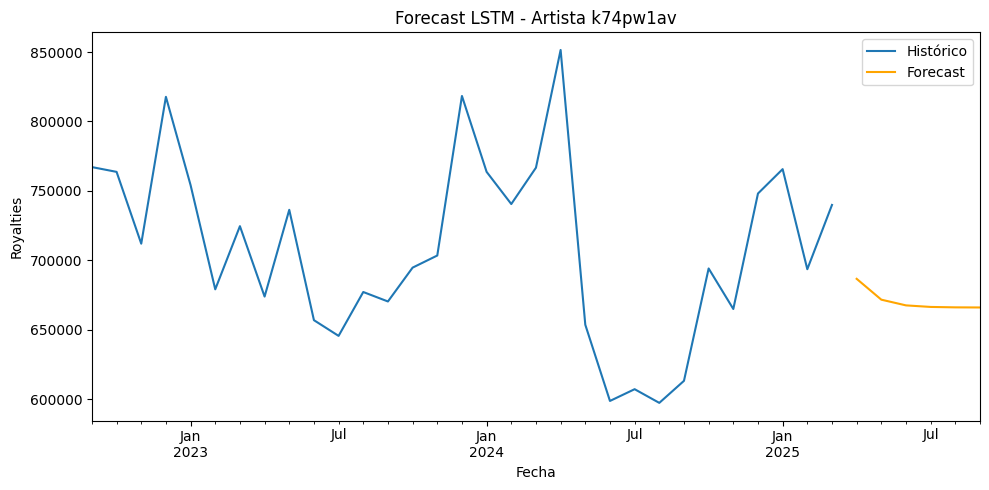

Gráfico de forecast para el artista kcw3uapo


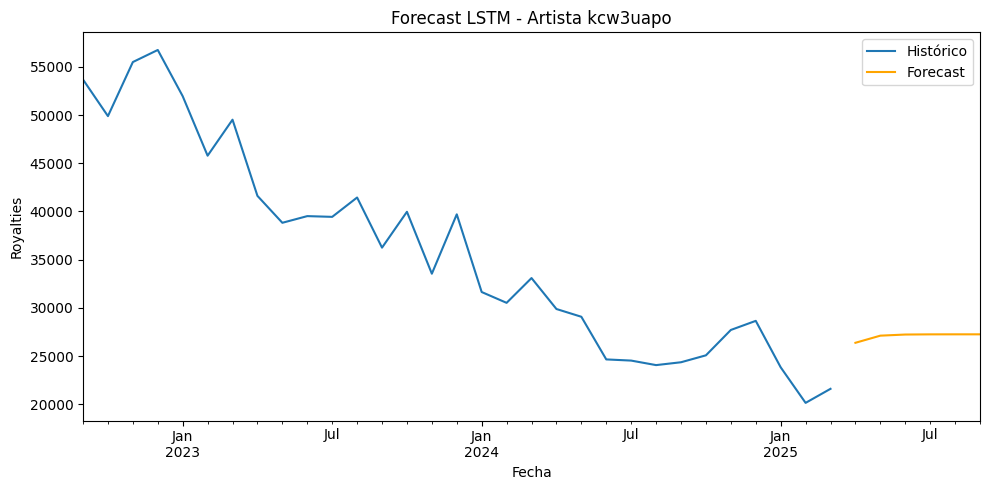

Gráfico de forecast para el artista pymr5w10


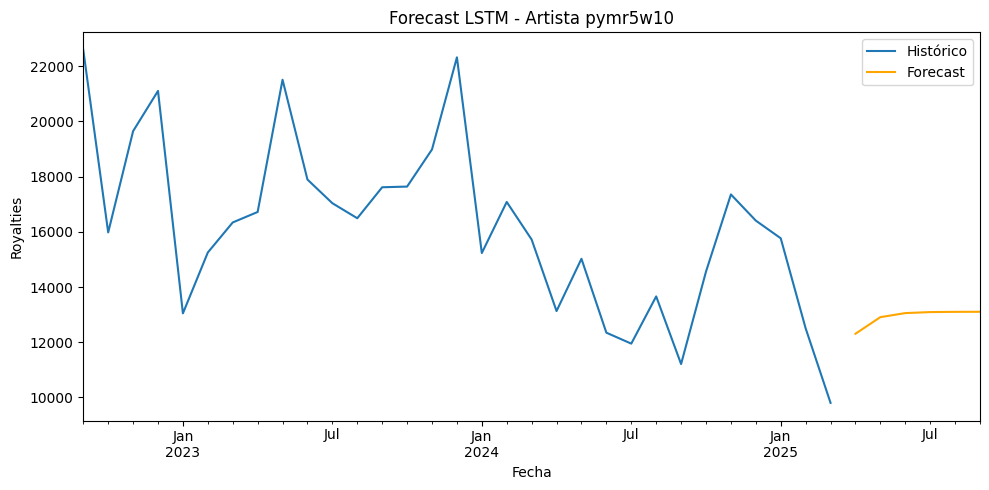

Gráfico de forecast para el artista r976ytqo


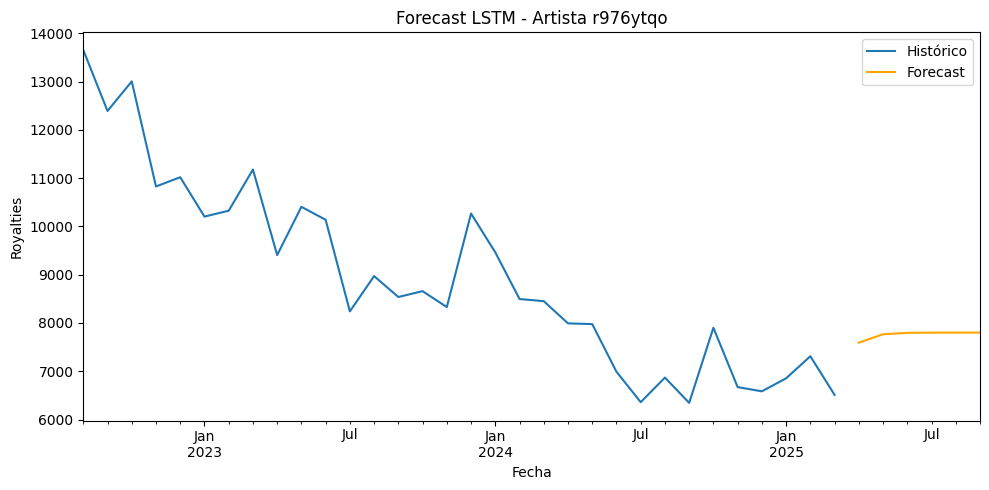

In [11]:
# Mostrar gráficos
for artist_id, figura in lista_figuras:
    print(f"Gráfico de forecast para el artista {artist_id}")
    display(figura)


In [12]:
# Guardar
df_forecasts_consolidado.to_csv('lstm_forecast_royalties_artistas.csv', index=False)
